<a href="https://colab.research.google.com/github/Putt2020/pytorch_beginner/blob/main/pytorch_CNN_beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(train_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16484580.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 495850.14it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4525701.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2316455.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
# Create data loader with batch size of 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [5]:
#Define CNN Model

"""
in_channels=1, input -> WxH image with 1 channel (grayscale)
out_channels=10, -> Amount of feature layers we want to create (will get 10xW'xH')
kernel_size=3, -> size of the filter in this case it is 3x3
stride=1, -> how much the filter moves in this case is 1 pixel at a time
padding=1 -> pad the border of the image with 0 i.e. from 10x10 to 12x12
"""
conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)

In [6]:
for i, (X_train, y_train) in enumerate(train_loader):
    print(i, X_train.shape, y_train.shape)
    break

0 torch.Size([32, 1, 28, 28]) torch.Size([32])


In [7]:
# Create CNN model class
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1) #from (32,1,28,28) to (32,10,28,28) becasue kernel = -2 and padding = +2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #from (32,10,28,28) to (32,10,14,14)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1) #from (32,10,14,14) to (32,20,14,14)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #from (32,10,14,14) to (32,10,7,7)
        self.fc1 = nn.Linear(in_features=20*7*7, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.pool1(X)
        X = F.relu(self.conv2(X))
        X = self.pool2(X)

        # Use view to flattern data
        X = X.view(-1, 20*7*7)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


In [8]:
#Create an instance of model
torch.manual_seed(42)
model = CNN_Model()
model

CNN_Model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=980, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
#Optimzer and loss
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
import time
start = time.time()


# Create params
epoch = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#Looping
for i in range(epoch):
    trn_corr = 0
    tst_corr = 0

    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1 #start the batch at 1
        y_pred = model(X_train) #get predicted data without flattened
        loss = criteria(y_pred, y_train) #How off the mark our data is

        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct prediction. indexed off the first point
        batch_corr = (predicted == y_train).sum() # The number of data that is correctly predicted in a batch
        trn_corr += batch_corr

        # Update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #display
        if b % 450 == 0:
            print(f'epoch: {i}  batch: {b}  loss: {loss.item()} accuracy: {trn_corr.item()*100/(32*b)}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad(): # No gradient -> No update weight backward
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criteria(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

stop = time.time()
print(f'Total time: {stop-start} seconds or {(stop-start)/60} minutes')

epoch: 0  batch: 450  loss: 0.08128085732460022 accuracy: 81.72916666666667%
epoch: 0  batch: 900  loss: 0.21808575093746185 accuracy: 88.44444444444444%
epoch: 0  batch: 1350  loss: 0.13546916842460632 accuracy: 91.05555555555556%
epoch: 0  batch: 1800  loss: 0.013936799019575119 accuracy: 92.58854166666667%
epoch: 1  batch: 450  loss: 0.08836116641759872 accuracy: 97.38888888888889%
epoch: 1  batch: 900  loss: 0.048193108290433884 accuracy: 97.69791666666667%
epoch: 1  batch: 1350  loss: 0.03977937251329422 accuracy: 97.8425925925926%
epoch: 1  batch: 1800  loss: 0.006806275807321072 accuracy: 97.91319444444444%
epoch: 2  batch: 450  loss: 0.010856661014258862 accuracy: 98.4375%
epoch: 2  batch: 900  loss: 0.04258913919329643 accuracy: 98.53472222222223%
epoch: 2  batch: 1350  loss: 0.022079797461628914 accuracy: 98.52777777777777%
epoch: 2  batch: 1800  loss: 0.05593843758106232 accuracy: 98.49826388888889%
epoch: 3  batch: 450  loss: 0.0021679443307220936 accuracy: 98.8888888888888

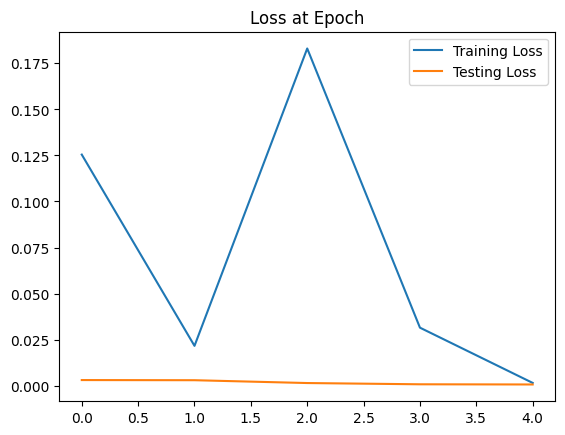

In [13]:
#grap the loss at epoch
train_losses = [item.item() for item in train_losses]
# test_losses = [item.item() for item in test_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()
#

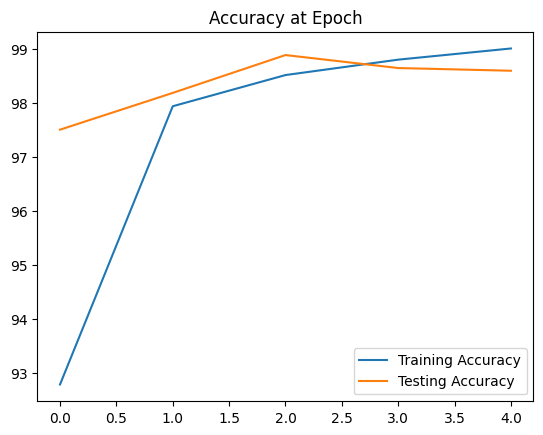

In [16]:
#graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy') # 600 come from train datasize/100
plt.plot([t/100 for t in test_correct], label='Testing Accuracy') # 100 come from test datasize/100
plt.title('Accuracy at Epoch')
plt.legend()

In [35]:
#Save model
torch.save(model.state_dict(), 'CNN_model.pt')

In [17]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [19]:
with torch.no_grad():
    correct = 0
    for images, labels in test_load_everything:
        output = model(images)
        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == labels).sum()
print(f'Accuracy: {correct.item()/100}%')

Accuracy: 98.59%


In [29]:
#function for testing new image
def guess_image(img, label=None):
    #Preview a test data
    plt.imshow(img.view(28,28), interpolation='nearest')
    if label:
        plt.title(label)
    else:
        plt.title("An image of number")
    plt.show()

    # Pass image through model
    model.eval()
    with torch.no_grad():
        output = model(img.view(1,1,28,28))
        print(f"output = {output}")
        print(f"answer = {output.argmax()}")
        if label:
            print(f"label = {label}")

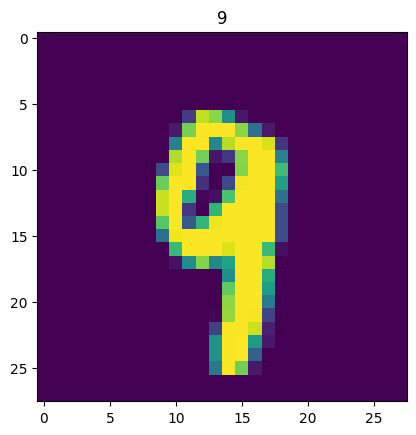

output = tensor([[-1.5352e+01, -1.6016e+01, -1.6932e+01, -1.4607e+01, -8.0920e+00,
         -1.7354e+01, -2.2105e+01, -9.5468e+00, -1.0394e+01, -4.0892e-04]])
answer = 9
label = 9


In [32]:
images, labels = test_data[4143]
guess_image(images, labels)

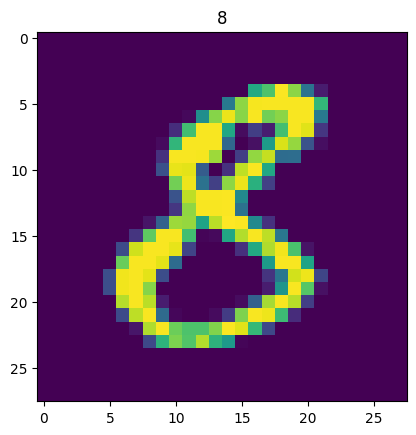

output = tensor([[-1.6260e+01, -1.8656e+01, -1.6666e+01, -1.1548e+01, -1.7324e+01,
         -8.4872e+00, -9.6804e+00, -2.1573e+01, -2.8046e-04, -1.3117e+01]])
answer = 8
label = 8


In [33]:
images, labels = test_data[1234]
guess_image(images, labels)

#ONNX Convertion

In [40]:
!pip install onnxruntime
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 59.3 MB/s eta 0:00:00


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
#convert model to onnx
#BIG NOTE according to https://github.com/microsoft/onnxruntime/issues/11635: ONNX will only eat data in 4D if maxpooling is included: (batch_num, Number of data, Height, Width)
torch.onnx.export(model,                                # model being run
                  torch.randn(1, 1, 28, 28).to(device),    # model input (or a tuple for multiple inputs)
                  "fashion_mnist_model.onnx",           # where to save the model (can be a file or file-like object)
                  input_names = ['input'],              # the model's input names
                  output_names = ['output'],            # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [58]:
# Load model
import onnx
onnx_model = onnx.load("fashion_mnist_model.onnx")
onnx.checker.check_model(onnx_model)

In [66]:
# Try prediction using ONNX model
import onnxruntime as ort
import numpy as np
def predict_in_onnx(data):
    x, y = data

    plt.imshow(x.view(28,28), interpolation='nearest')
    plt.title(y)
    plt.show()

    ort_sess = ort.InferenceSession('fashion_mnist_model.onnx')
    outputs = ort_sess.run(None, {'input': x.view(1,1,28,28).numpy()})

    # Print Result
    predicted, actual = outputs[0][0].argmax(0), y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

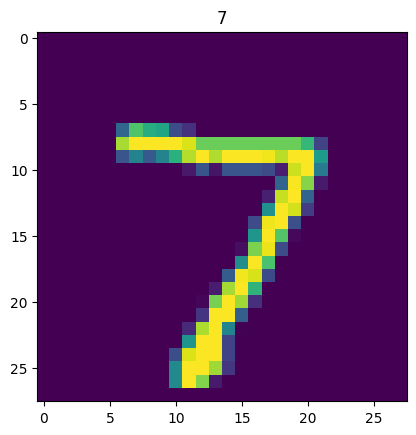

Predicted: "7", Actual: "7"


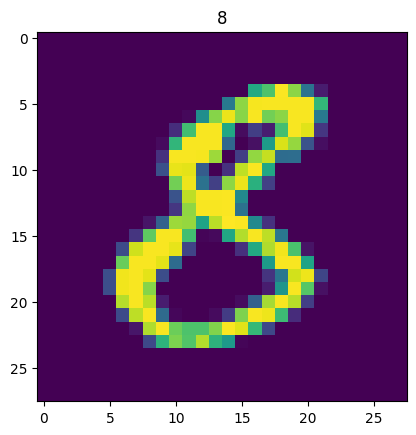

Predicted: "8", Actual: "8"


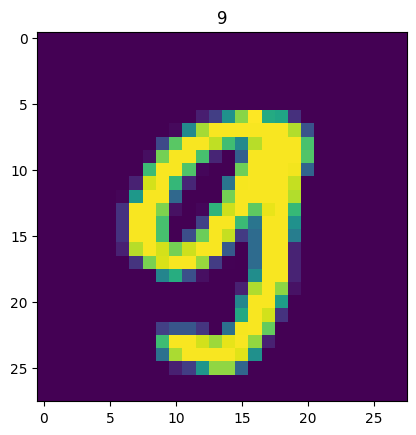

Predicted: "9", Actual: "9"


In [68]:
predict_in_onnx(test_data[0])
predict_in_onnx(test_data[1234])
predict_in_onnx(test_data[4321])